In [1]:
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.filterwarnings('ignore', category=ConvergenceWarning)
from IPython.display import clear_output

In [2]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from Local_Library import data_prep, kalman_filter, data_prep_arima, data_prep_svr, arch_volatility_predictor, svr_predictor
from Local_Library import garch_volatility_predictor, LSTM_predictor, arima_predictor
from keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from sklearn.svm import SVR

In [3]:
years = 2 
ETF_df = pd.read_csv('ETF_df.csv').iloc[-252*years:,111] # Selecting the latest two years of ETF data to test ML models.
ETF_data = ETF_df.dropna() # Removing missing values.
ETF_returns_df = ETF_data.pct_change() # Estimating % returns.
ETF_returns_data = pd.Series(ETF_returns_df) # Converting ETF data to series format.
window = 22

## ARCH

In [4]:
prep_data = data_prep(ETF_returns_data, 'Actual_Return', window, dropna=True, scale=True) # Preparing data structures for ARCH model.
prep_data['X_train_var_arch'] = prep_data['X_train'].apply(lambda x: arch_volatility_predictor(x)) # Applying ARCH model on each row of the prepared data.

In [5]:
prep_data['X_train_var_arch_filtered'] = kalman_filter(prep_data['X_train_var_arch'].values) # Applying kalman filter to de-noise the data.
X_train_var_adjusted = prep_data['X_train_var'][1:] # Adjusting for prediction shift.
X_train_var_arch_filtered_adjusted = prep_data['X_train_var_arch_filtered'][:-1] # Adjusting for prediction shift.
prep_data_arch_adjusted = pd.DataFrame(list(zip(
    X_train_var_adjusted, X_train_var_arch_filtered_adjusted)), columns=['X_train_var_adjusted', 
                                                                         'X_train_var_arch_filtered_adjusted']) # Storing required information in a data frame.


In [6]:
print('ARCH RMSE:', np.sqrt(mean_squared_error(prep_data_arch_adjusted[['X_train_var_adjusted']], 
                                               prep_data_arch_adjusted[['X_train_var_arch_filtered_adjusted']]))) # Calculating and printing ARCH rmse.

print('ARCH MSE:', mean_squared_error(prep_data_arch_adjusted[['X_train_var_adjusted']], 
                                               prep_data_arch_adjusted[['X_train_var_arch_filtered_adjusted']])) # Calculating and printing ARCH mse.

print('ARCH MAE:', np.mean(np.abs(prep_data_arch_adjusted['X_train_var_adjusted'] -
                                  prep_data_arch_adjusted['X_train_var_arch_filtered_adjusted']))) # Calculating and printing ARCH mae.


ARCH RMSE: 0.21754894029590177
ARCH MSE: 0.047327541423869836
ARCH MAE: 0.15266819126055295


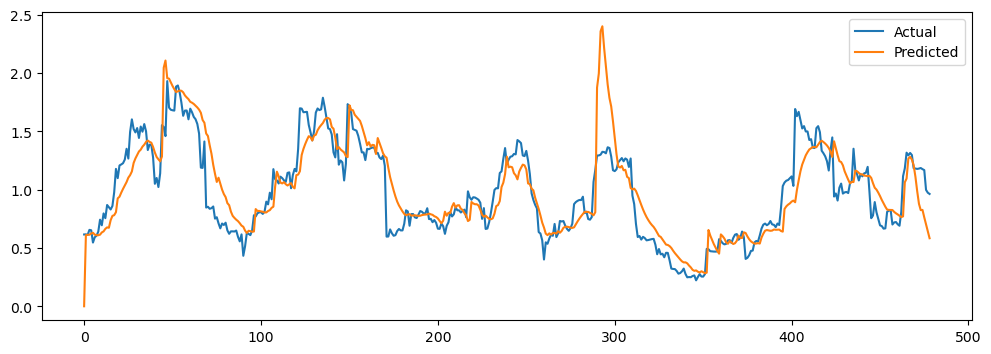

In [7]:
arch_plot = prep_data_arch_adjusted[['X_train_var_adjusted','X_train_var_arch_filtered_adjusted']].plot(figsize=(12,4)); # Printing real and estimated volatility.
arch_plot.legend(['Actual', 'Predicted'])
arch_plot.figure.savefig('arch_plot.png')

## GARCH

In [8]:
prep_data_garch = data_prep(ETF_returns_data, 'Actual_Return', window, dropna=True, scale=True) # Preparing data structures for GARCH model.
prep_data_garch['X_train_var_garch'] = prep_data_garch['X_train'].apply(lambda x: garch_volatility_predictor(x)) # Applying GARCH model on each row of the prepared data.


In [9]:
prep_data_garch['X_train_var_garch_filtered'] = kalman_filter(prep_data_garch['X_train_var_garch'].values) # Applying kalman filter to de-noise the data.
X_train_var_adjusted = prep_data_garch['X_train_var'][1:] # Adjusting for prediction shift.
X_train_var_garch_filtered_adjusted = prep_data_garch['X_train_var_garch_filtered'][:-1] # Adjusting for prediction shift.
prep_data_garch_adjusted = pd.DataFrame(list(zip(
    X_train_var_adjusted, X_train_var_garch_filtered_adjusted)), columns=['X_train_var_adjusted', 
                                                                         'X_train_var_garch_filtered_adjusted']) # Storing required information in a data frame.


In [10]:
print('GARCH RMSE:', np.sqrt(mean_squared_error(prep_data_garch_adjusted[['X_train_var_adjusted']], 
                                               prep_data_garch_adjusted[['X_train_var_garch_filtered_adjusted']]))) # Calculating and printing GARCH rmse.

print('GARCH MSE:', mean_squared_error(prep_data_garch_adjusted[['X_train_var_adjusted']], 
                                               prep_data_garch_adjusted[['X_train_var_garch_filtered_adjusted']])) # Calculating and printing GARCH mse.

print('GARCH MAE:', np.mean(np.abs(prep_data_garch_adjusted['X_train_var_adjusted'] -
                                  prep_data_garch_adjusted['X_train_var_garch_filtered_adjusted']))) # Calculating and printing GARCH mae.


GARCH RMSE: 0.1679496465801336
GARCH MSE: 0.02820708378639178
GARCH MAE: 0.12054531578326534


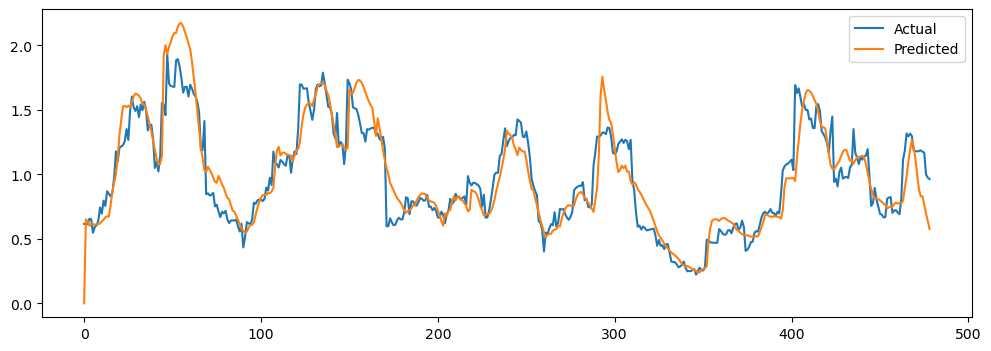

In [11]:
garch_plot = prep_data_garch_adjusted[['X_train_var_adjusted','X_train_var_garch_filtered_adjusted']].plot(figsize=(12,4)); # Printing real and estimated volatility.
garch_plot.legend(['Actual', 'Predicted'])
garch_plot.figure.savefig('garch_plot.png')


## LSTM

In [12]:
data_df_lstm  = data_prep_arima(ETF_returns_data, 'Actual_Return', 
                                'Actual_Variance', window, dropna=True, scale=True) # Preparing data structures for LSTM model.
input_shape = (window, 1) # Shape of the input data based on volatility window length.
# Instantiating the LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(50, return_sequences=True, input_shape=input_shape))
lstm_model.add(LSTM(50, return_sequences=False))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse')

data_df_lstm["Predicted_Variance"] = data_df_lstm[[
    'X_train','y_train','X_test']].apply(lambda x: LSTM_predictor(
    lstm_model, x['X_train'],x['y_train'],x['X_test'])[0][0], axis=1) # Applying LSTM model on each row of the prepared data.


In [13]:
print('LSTM RMSE:', np.sqrt(mean_squared_error(data_df_lstm[['y_test']], 
                                               data_df_lstm[['Predicted_Variance']]))) # Calculating and printing LSTM rmse.

print('LSTM MSE:', mean_squared_error(data_df_lstm[['y_test']], 
                                               data_df_lstm[['Predicted_Variance']])) # Calculating and printing LSTM mse.

print('LSTM MAE:', np.mean(np.abs(data_df_lstm['y_test'] -
                                  data_df_lstm['Predicted_Variance']))) # Calculating and printing LSTM mae.



LSTM RMSE: 0.3996198458227445
LSTM MSE: 0.1596960211753941
LSTM MAE: 0.2714884997606697


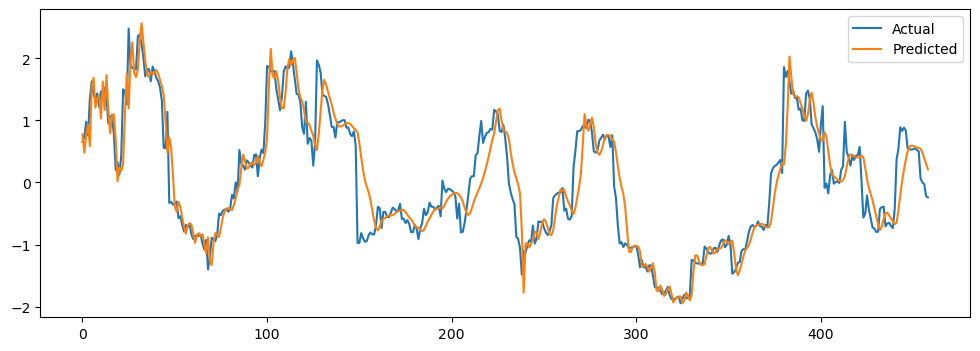

In [14]:
lstm_plot = data_df_lstm[['y_test','Predicted_Variance']].plot(figsize=(12,4)); # Printing real and estimated volatility.lst
lstm_plot.legend(['Actual', 'Predicted'])
lstm_plot.figure.savefig('lstm_plot.png')


## SVR

In [15]:
window = 22
prep_data_svr  = data_prep_svr(ETF_returns_data, 'Actual_Return', 
                               'Actual_Variance', window, dropna=True, scale=True) # Preparing data structures for SVR model.
# Instantiating the SVR model
svr_model = SVR(kernel='rbf', C=1000, gamma=0.1)

prep_data_svr["Predicted_Variance"] = prep_data_svr[[
    'X_train','y_train','X_test']].apply(lambda x: svr_predictor(
    svr_model, x['X_train'],x['y_train'],x['X_test'])[0], axis=1) # Applying SVR model on each row of the prepared data.


In [16]:
y_test_adjusted = [x[0] for x in prep_data_svr.y_test.values] # Extracting test data which is used for SVR model analysis.
y_predicted = prep_data_svr['Predicted_Variance'] # Extracting predicted data which is used for SVR model analysis.

prep_data_svr_adjusted = pd.DataFrame(list(zip(
    y_test_adjusted, y_predicted)), columns=['y_test_adjusted','y_predicted']) # Storing required information in a data frame.


In [17]:
print('SVR RMSE:', np.sqrt(mean_squared_error(prep_data_svr_adjusted[['y_test_adjusted']], 
                                               prep_data_svr_adjusted[['y_predicted']]))) # Calculating and printing SVR rmse.

print('SVR MSE:', mean_squared_error(prep_data_svr_adjusted[['y_test_adjusted']], 
                                               prep_data_svr_adjusted[['y_predicted']])) # Calculating and printing SVR mse.

print('SVR MAE:', np.mean(np.abs(prep_data_svr_adjusted['y_test_adjusted'] -
                                  prep_data_svr_adjusted['y_predicted']))) # Calculating and printing SVR mae.



SVR RMSE: 0.2085473911426038
SVR MSE: 0.04349201435238618
SVR MAE: 0.13775975074502494


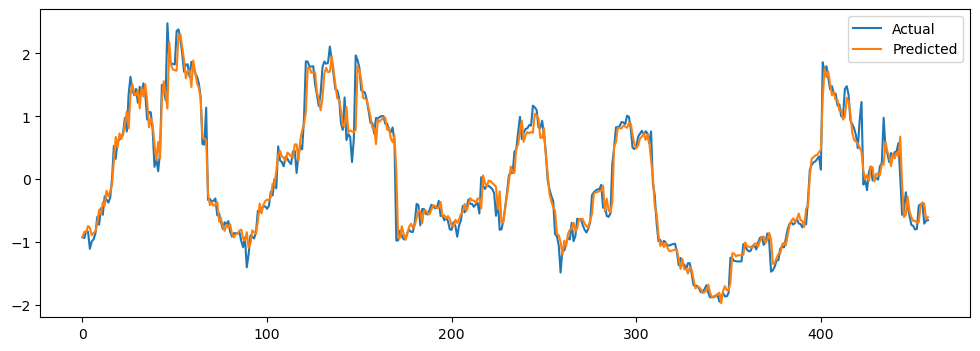

In [18]:
svr_plot = prep_data_svr_adjusted[['y_test_adjusted',"y_predicted"]].plot(figsize=(12,4)); # Printing real and estimated volatility.
svr_plot.legend(['Actual', 'Predicted'])
svr_plot.figure.savefig('svr_plot.png')


## ARIMA

In [19]:
window = 22
prep_data_arima = data_prep_arima(ETF_returns_data, 'Actual_Return', 
                                  'Actual_Variance', window, dropna=True, scale=True) # Preparing data structures for ARIMA model.

prep_data_arima["Predicted_Variance"] = prep_data_arima[
    'X_train'].apply(lambda x: arima_predictor(x)[0]) # Applying ARIMA model on each row of the prepared data.

clear_output()


In [20]:
print('ARIMA RMSE:', np.sqrt(mean_squared_error(prep_data_arima[['y_test']],
                                                                prep_data_arima[['Predicted_Variance']]))) # Calculating and printing ARIMA rmse.

print('ARIMA MSE:', mean_squared_error(prep_data_arima[['y_test']], 
                                               prep_data_arima[['Predicted_Variance']])) # Calculating and printing ARIMA mse.

print('ARIMA MAE:', np.mean(np.abs(prep_data_arima['y_test'] -
                                  prep_data_arima['Predicted_Variance']))) # Calculating and printing ARIMA mae.



ARIMA RMSE: 0.41267708541770604
ARIMA MSE: 0.17030237682885263
ARIMA MAE: 0.2761724769962112


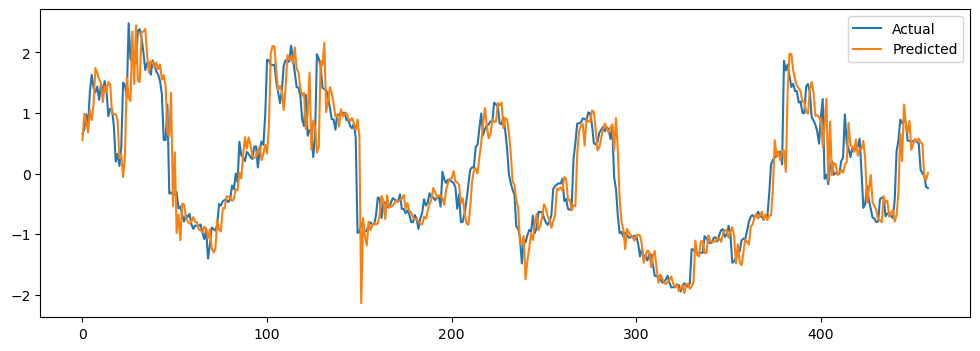

In [21]:
arima_plot = prep_data_arima[['y_test','Predicted_Variance']].plot(figsize=(12,4)); # Printing real and estimated volatility.
arima_plot.legend(['Actual', 'Predicted'])
arima_plot.figure.savefig('arima_plot.png')
